### Read in images, define imports

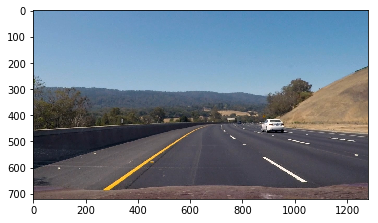

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import glob
#%matplotlib qt

image1 = mpimg.imread('test_images/test3.jpg')
plt.imshow(image1)

images = glob.glob('camera_cal/calibration*.jpg')

### Calibrate camera and compute distortion coefficients and camera matrix

In [2]:
objpts = [] #3D points in real world, with z = 0
imgpts = [] #2D points in image space

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        objpts.append(objp)
        imgpts.append(corners)
    
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.imshow(img)
objpts = np.asarray(objpts)
objpts = objpts.astype('float32')
gray = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
ret1, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, gray.shape[::-1], None, None)


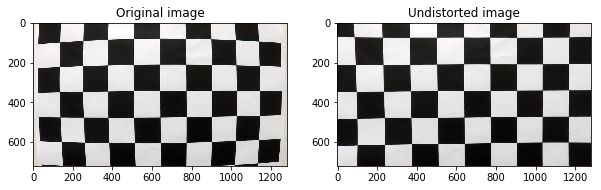

In [3]:
chess1 = mpimg.imread(images[0])
undist_chess = cv2.undistort(chess1, mtx, dist)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(chess1)
plt.subplot(1,2,2)
plt.title('Undistorted image')
plt.imshow(undist_chess)

plt.savefig('./examples/chess_undist.png')

### Apply distortion correction to image

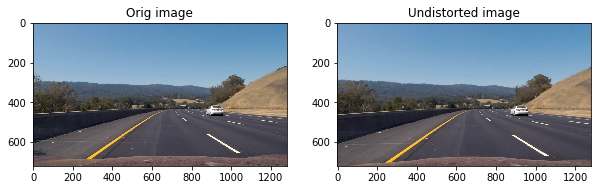

In [4]:
undist = cv2.undistort(image1, mtx, dist)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('Orig image')
plt.imshow(image1)
plt.subplot(1,2,2)
plt.title('Undistorted image')
plt.imshow(undist)

plt.savefig('./examples/test3.png')

### Define functions to apply color and gradient thresholding to images

In [5]:
# define gradient thresholds

def sobel_abs_grad(img, orient='x', kernel=3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sb = cv2.Sobel(gray, cv2.CV_64F, 1, 0, kernel)
    else:
        sb = cv2.Sobel(gray, cv2.CV_64F, 0, 1, kernel)
    sb = np.absolute(sb)
    sb = np.uint8(255*sb/np.max(sb))
    binary_op = np.zeros_like(sb)
    binary_op[(sb > thresh[0])&(sb < thresh[1])] = 1
    return binary_op

def sobel_dir_grad(img, kernel=3, thresh=(0,np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, kernel)
    sy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, kernel)
    grad = np.arctan(sy,sx)
    binary_op = np.zeros_like(grad)
    binary_op[(grad > thresh[0])&(grad < thresh[1])] = 1
    return binary_op

def r_thresh(img, thresh=(0,255)):
    r_ch = img[:,:,0]
    binary_op = np.zeros_like(r_ch)
    binary_op[(r_ch > thresh[0])&(r_ch < thresh[1])] = 1
    return binary_op

def s_thresh(img, thresh=(0,255)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_ch = img[:,:,2]
    binary_op = np.zeros_like(s_ch)
    binary_op[(s_ch > thresh[0])&(s_ch < thresh[1])] = 1
    return binary_op

def l_thresh(img, thresh=(0,255)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_ch = img[:,:,1]
    binary_op = np.zeros_like(l_ch)
    binary_op[(l_ch > thresh[0])&(l_ch <thresh[1])] = 1
    return binary_op

### Apply combination of color and gradient threshold to get binary image

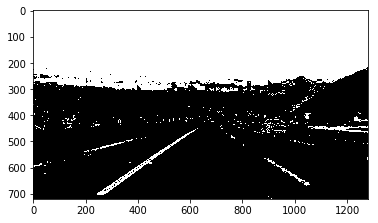

In [6]:
threshImg = s_thresh(undist, (90,255))
#plt.imshow(threshImg, cmap='gray')

gradImg = sobel_abs_grad(undist, 'x', 3, (40,100))
#combined color and gradient threshold
combImg = np.zeros_like(threshImg)
combImg[(threshImg == 1) | (gradImg == 1)] = 1
plt.imshow(combImg, cmap='gray')
plt.savefig('./examples/binary_threshold.png')

### Visualize source and destination points for perspective transform

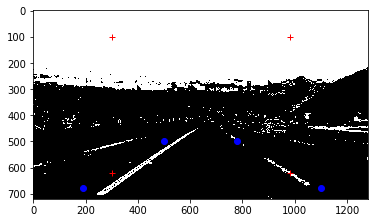

In [7]:
lefttop = 550
righttop = 730
rightbottom = 1050
leftbottom = 240

plt.imshow(combImg, cmap='gray')
plt.plot(lefttop-50,500,'bo')
plt.plot(righttop+50,500,'bo')
plt.plot(rightbottom+50,680,'bo')
plt.plot(leftbottom-50,680,'bo')

plt.plot(300,100,'r+')
plt.plot(combImg.shape[1]-300,100,'r+')
plt.plot(combImg.shape[1]-300,combImg.shape[0]-100,'r+')
plt.plot(300,combImg.shape[0]-100,'r+')

plt.savefig('./examples/perspective_mapping.png')

### Apply perspective transform on the image to get a 'bird's eye view'

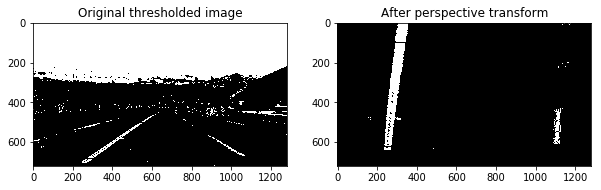

In [8]:
def warpImg(img, offsetx=400, offsety=400):
    #corners = np.array([(img.shape[0]/3.0,img.shape[1]/3.0),(img.shape[0]*2.0/3.0,img.shape[1]/3.0),(img.shape[0]*2.0/3.0,img.shape[1]*2.0/3.0),
                      #(img.shape[0]/3.0, img.shape[1]*2.0/3.0)])
    src = np.float32([[lefttop-50,500],[righttop+50,500],[rightbottom+50,680],[leftbottom-50,680]])
    #src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([[offsetx,offsety],[img.shape[1]-offsetx, offsety], [img.shape[1]-offsetx,img.shape[0]-offsety],
                     [offsetx,img.shape[0]-offsety]])
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    img_size = (img.shape[1],img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return (warped,Minv)

#print(combImg.shape)
(warped,Minv) = warpImg(combImg, 150, 100)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('Original thresholded image')
pts = np.array([[lefttop - 50,500],[righttop+50,500],[rightbottom+50,680],[leftbottom-50,680]],np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(combImg,[pts],True,(0,255,0),3)
plt.imshow(combImg, cmap='gray')
plt.subplot(1,2,2)
plt.title('After perspective transform')
offsetx = 150
offsety = 100
pts = np.array([[offsetx,offsety],[img.shape[1]-offsetx, offsety], [img.shape[1]-offsetx,img.shape[0]-offsety],
                     [offsetx,img.shape[0]-offsety]],np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(warped,[pts],False,(0,255,0),3)
plt.imshow(warped, cmap='gray')

plt.savefig('./examples/top_view.png')

### Function to detect and draw lane lines

In [9]:
def drawLines(img, drawRect=False):
    out_img = np.dstack((img,img,img))*255
    #histogram to find pixels contributing to lane lines
    hist = np.sum(img[img.shape[0]//2:,:],axis=0)
    #plt.plot(hist)
    #print(hist.shape)

    midpoint = np.int(hist.shape[0]/2)
    
    # Since the left lane line will be much more to the left of the midpoint, search only up to margin before midpoint
    leftMid = np.argmax(hist[:midpoint-250])
    # Since the right lane line will be much more to the right of the midpoint, start search only from a margin after
    # midpoint
    rightMid = np.argmax(hist[midpoint+300:])+midpoint+300

    nwindows = 9
    margin = 100
    minpix = 100
    windHeight = np.int(img.shape[0]/nwindows)
    
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    #print(nonzerox)
    
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    
    left_fit=[]
    right_fit=[]

    for window in range(nwindows):
        w_high = img.shape[0] - window*windHeight
        w_low = img.shape[0] - (window+1)*windHeight
        w_left_low = leftMid - margin
        w_left_high = leftMid + margin
        w_right_low = rightMid - margin
        w_right_high = rightMid + margin
        
        if drawRect==True:
            cv2.rectangle(out_img,(w_left_low,w_low),(w_left_high,w_high),(0,255,0),3)
            cv2.rectangle(out_img,(w_right_low,w_low),(w_right_high,w_high),(0,255,0),3)
        
        #find non-zero pixels within window
        left_indices = ((nonzerox > w_left_low) & (nonzerox < w_left_high) & (nonzeroy > w_low) & (nonzeroy < w_high))
        right_indices = ((nonzerox > w_right_low) & (nonzerox < w_right_high) & (nonzeroy > w_low) & (nonzeroy < w_high))
        
        left_pixels_x = nonzerox[left_indices]
        left_pixels_y = nonzeroy[left_indices]
        right_pixels_x = nonzerox[right_indices]
        right_pixels_y = nonzeroy[right_indices]
        
        if len(left_pixels_x) > minpix:
            leftMid = np.int(np.mean(left_pixels_x))
        if len(right_pixels_x) > minpix:
            rightMid = np.int(np.mean(right_pixels_x))
        
        left_x.extend(left_pixels_x)
        left_y.extend(left_pixels_y)
        right_x.extend(right_pixels_x)
        right_y.extend(right_pixels_y)
    
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
    return (out_img,left_fit,right_fit)


### Fit a 2nd order polynomial onto detected lane lines

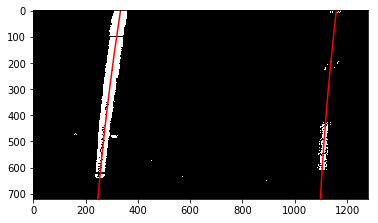

In [10]:
(out_img,leftfit, rightfit) = drawLines(warped)
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
left_fitx = leftfit[0]*ploty**2 + leftfit[1]*ploty + leftfit[2]
right_fitx = rightfit[0]*ploty**2 + rightfit[1]*ploty + rightfit[2]
plt.imshow(out_img)
plt.plot(left_fitx,ploty,color='red')
plt.plot(right_fitx,ploty,color='red')

plt.savefig('./examples/fit_lines.png')

### Calculate radius of curvature and position wrt center of image

In [11]:
#curvature in real world space
ym_per_pix = 10/720 #meters per pixel in y dim
xm_per_pix = 3.7/880 # meters per pixel in x dim

y_eval = np.max(ploty)

# Compute polyfit for (x,y) cooradinates in real world
left_real_fitx = np.polyfit(ploty*ym_per_pix,left_fitx*xm_per_pix,2)
right_real_fitx = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix,2)

# Compute radius of curvature of left and right lane line
left_rad = ((1 + (2*left_real_fitx[0]*y_eval*ym_per_pix + left_real_fitx[1])**2)**1.5)/np.absolute(2*left_real_fitx[0])
right_rad = ((1 + (2*right_real_fitx[0]*y_eval*ym_per_pix + left_real_fitx[1])**2)**1.5)/np.absolute(2*right_real_fitx[0])

print('Left radius',left_rad,'m ','Right radius', right_rad,'m')

#compute offset of lane center from center of image
left_pt = leftfit[0]*(y_eval)**2 + leftfit[1]*y_eval + leftfit[2]
right_pt = rightfit[0]*(y_eval)**2 + rightfit[1]*y_eval + rightfit[2]
offsetC = (left_pt + right_pt)/2
offsetC = np.absolute(offsetC - 640) * xm_per_pix # offset from image center, convert from pixels to meters
print('Offset of vehicle from center: %f m'%offsetC)

Left radius 494.207826273 m  Right radius 562.501008019 m
Offset of vehicle from center: 0.137040 m


### Project lane lines back to real world perspective

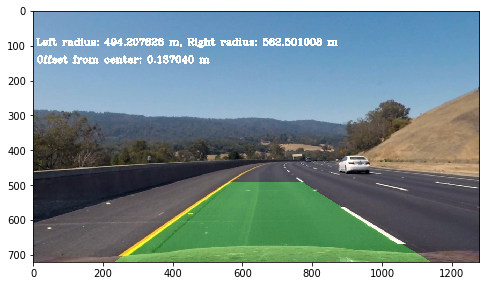

In [12]:
# project lines onto real world image
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero,warp_zero,warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx,ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
pts = np.hstack((pts_left, pts_right))

cv2.fillPoly(color_warp,np.int_([pts]),(0,255,0))

poly_img = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0]), flags=cv2.INTER_LINEAR)

result = cv2.addWeighted(undist,1,poly_img,0.3,0)
textString = 'Left radius: %f m, Right radius: %f m'%(left_rad, right_rad)
cv2.putText(result, textString,(10,100),cv2.FONT_HERSHEY_COMPLEX,0.9,(255,255,255),3)
cv2.putText(result, 'Offset from center: %f m'%offsetC,(10,150),cv2.FONT_HERSHEY_COMPLEX,0.9,(255,255,255),3)
plt.figure(figsize=(8,8))
plt.imshow(result)
plt.savefig('./examples/out_test3.png')

### Test on Video

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
# Define a class 'Line' to hold information from previous video frames
class Line():
    def __init__(self):
        self.num_frames = 0
        self.last_linefit = []
        self.last_radCurve = None
        self.avgfit_N_frames = []

leftLane = Line()
rightLane = Line()

In [17]:
def process_image(img):
    # We already have dist and camera mtx from calibration on chessboard images
    # Use these for distortion correction
    undist = cv2.undistort(img, mtx, dist)
    threshImg = s_thresh(undist, (90,255))

    gradImg = sobel_abs_grad(undist, 'x', 3, (40,100))
    combImg = np.zeros_like(threshImg)
    combImg[(threshImg == 1) | (gradImg == 1)] = 1
    (warped,Minv) = warpImg(combImg, 150, 100)
    
    (out_img,leftfit, rightfit) = drawLines(warped)
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    left_fitx = leftfit[0]*ploty**2 + leftfit[1]*ploty + leftfit[2]
    right_fitx = rightfit[0]*ploty**2 + rightfit[1]*ploty + rightfit[2]
    
    y_eval = np.max(ploty)
    # if lines detected in previous frame, average with polyfits of previous frame
    if leftLane.num_frames>0:
        left_fitx = (np.array(left_fitx) + np.array(leftLane.last_linefit))/2
        #element-wise difference between old line and new line
        diff = np.absolute(np.array(left_fitx) - np.array(leftLane.last_linefit))
        if (np.max(diff)>25):
            left_fitx = leftLane.last_linefit
    if rightLane.num_frames>0:
        right_fitx = (np.array(right_fitx) + np.array(rightLane.last_linefit))/2
        #element-wise difference between old line and new line
        diff = np.absolute(np.array(right_fitx) - np.array(rightLane.last_linefit))
        if (np.max(diff)>25):
            right_fitx = rightLane.last_linefit
    
    leftLane.num_frames += 1
    rightLane.num_frames += 1
    leftLane.last_linefit = left_fitx
    rightLane.last_linefit = right_fitx
     
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero,warp_zero,warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx,ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp,np.int_([pts]),(0,255,0))

    poly_img = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0]), flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(undist,1,poly_img,0.3,0)
    
    #find curvature of left and right lane lines in real world space
    ym_per_pix = 10/720 #meters per pixel in y dim
    xm_per_pix = 3.7/880 # meters per pixel in x dim

    left_real_fitx = np.polyfit(ploty*ym_per_pix,left_fitx*xm_per_pix,2)
    right_real_fitx = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix,2)

    left_rad = ((1 + (2*left_real_fitx[0]*y_eval*ym_per_pix + left_real_fitx[1])**2)**1.5)/np.absolute(2*left_real_fitx[0])
    right_rad = ((1 + (2*right_real_fitx[0]*y_eval*ym_per_pix + left_real_fitx[1])**2)**1.5)/np.absolute(2*right_real_fitx[0])

    leftfit = np.polyfit(ploty, left_fitx,2)
    rightfit = np.polyfit(ploty, right_fitx,2)
    
    #compute offset of lane center from center of image
    left_pt = leftfit[0]*(y_eval)**2 + leftfit[1]*y_eval + leftfit[2]
    right_pt = rightfit[0]*(y_eval)**2 + rightfit[1]*y_eval + rightfit[2]
    offsetC = (left_pt + right_pt)/2
    offsetC = np.absolute(offsetC - 640) * xm_per_pix # offset from image center, convert from pixels to meters
    
    textL = 'Left radius : %f m'%left_rad
    textR = 'Right radius: %f m'%right_rad
    textO = 'Offset from center: %f m'%offsetC
    font = cv2.FONT_HERSHEY_SIMPLEX
    cornerOfText = (100,30)
    fontScale = 0.7
    fontColor = (255,255,255)
    cv2.putText(result, textL,(30,100),font,fontScale,fontColor,2)
    cv2.putText(result, textR,(30,125),font,fontScale,fontColor,2)
    cv2.putText(result, textO,(30,150),font,fontScale,fontColor,2)
    return result

In [18]:
output_vid = 'project_video_out.mp4'

# First run on a shorter subclip for testing 
#clip1 = VideoFileClip('project_video.mp4').subclip(38,40)
clip1 = VideoFileClip('project_video.mp4')
processed_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(output_vid, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [03:00<00:00,  7.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 3min 28s, sys: 28.9 s, total: 3min 57s
Wall time: 3min 2s


#### DEBUG: To extract frames where lane detection fails, process individual and analyze

In [452]:
import os
from moviepy.editor import *

def extract_frames(movie, times, imgdir):
    clip = VideoFileClip(movie)
    for t in times:
        imgpath = os.path.join(imgdir, '{}.jpg'.format(t))
        clip.save_frame(imgpath, t)

movie = 'project_video.mp4'
imgdir = 'frames2'
times = 42.5, 42.7, 42.9, 50.1

extract_frames(movie, times, imgdir)

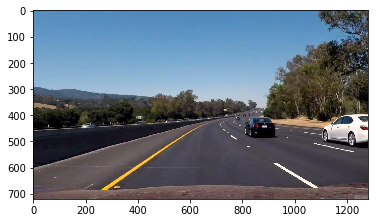

In [453]:
image1 = mpimg.imread('frames2/42.7.jpg')
plt.imshow(image1)

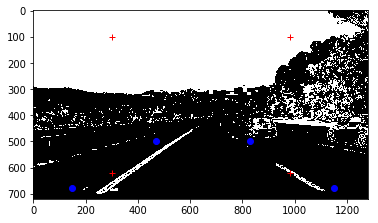

In [454]:
undist = cv2.undistort(image1, mtx, dist)
threshImg = s_thresh(undist, (90,255))
#plt.imshow(threshImg, cmap='gray')

gradImg = sobel_abs_grad(undist, 'x', 3, (40,100))
combImg = np.zeros_like(threshImg)
combImg[(threshImg == 1) | (gradImg == 1)] = 1
plt.imshow(combImg, cmap='gray')

plt.plot(lefttop-50,500,'bo')
plt.plot(righttop+50,500,'bo')
plt.plot(rightbottom+50,680,'bo')
plt.plot(leftbottom-50,680,'bo')

plt.plot(300,100,'r+')
plt.plot(combImg.shape[1]-300,100,'r+')
plt.plot(combImg.shape[1]-300,combImg.shape[0]-100,'r+')
plt.plot(300,combImg.shape[0]-100,'r+')

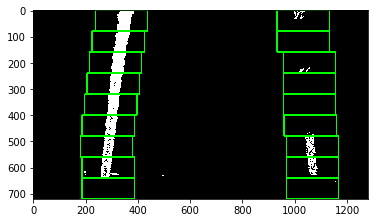

In [455]:
(warped,Minv) = warpImg(combImg, 150, 100)
plt.imshow(warped, cmap='gray')
(out_img,leftfit, rightfit) = drawLines(warped, True)
plt.imshow(out_img, cmap='gray')


8360.35790457 8656.4662898


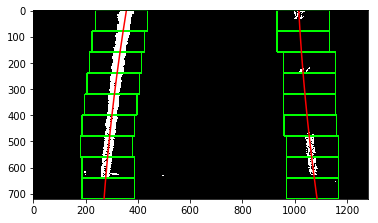

In [456]:
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
left_fitx = leftfit[0]*ploty**2 + leftfit[1]*ploty + leftfit[2]
right_fitx = rightfit[0]*ploty**2 + rightfit[1]*ploty + rightfit[2]
plt.imshow(out_img)

plt.plot(left_fitx,ploty,color='red')
plt.plot(right_fitx,ploty,color='red')

y_eval = np.int(np.max(ploty)/2)
left_curve_rad = ((1+ (2*leftfit[0]*y_eval + leftfit[1])**2)**1.5)/np.absolute(2*leftfit[0])
right_curve_rad = ((1 + (2*rightfit[0]*y_eval + rightfit[1])**2)**1.5)/np.absolute(2*rightfit[0])
print(left_curve_rad, right_curve_rad)
